In [1]:
from Variables import *
from LoadFunctions import *
from ThreeDWindRadarFunctions import *
from MatchFunctions import *
from OtherUsefulFunctions import *
from PlotInteractiveFunctions import *
from InteractiveFunctions import *
from Paths import *
from parametersPlot import *

import warnings
warnings.filterwarnings('ignore')
mode = 'high'

# Barbs

In [2]:
dateList=['2020712']
fontsize1 = 20
matplotlib.rcParams.update({'font.size': fontsize1})
optionFilter=4
optionSave = True
limitLow = 0.789
limitHigh = 7

Saving wind barbs for date : 2020712


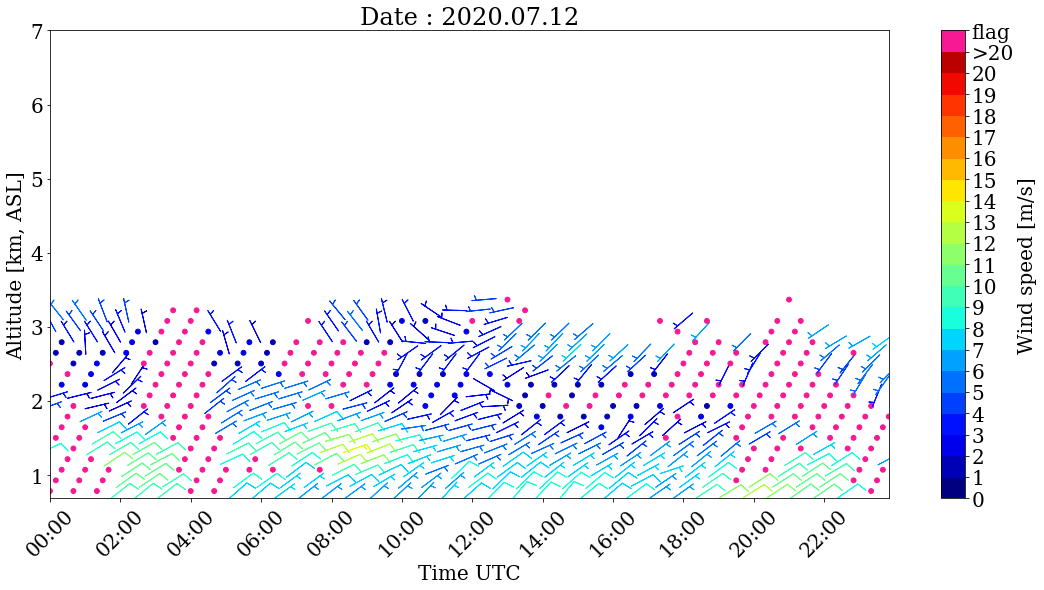

In [3]:
for chosenDate in dateList:
    # Load 
    folder_radar, filepaths_radar, filenames_radar, date_radar, date_radardt,radarNoFile = loadRadar(chosenDate, path_dat)
    folder_lidar, filepaths_lidar, filenames_lidar, date_lidar,date_lidardt,_,_,_,lidarNoFile = loadLidar(chosenDate, path_lidar)

    # Wind
    if (radarNoFile is False) and (lidarNoFile is False):
        path = path_highmode if mode == 'high' else path_lowmode

        df_aswFlag,optionFlag = concatASWradar(chosenDate, path, optionFlag=True)
        df_radialFlag = uvw2radial(df_aswFlag, beam_radar, elevationAngle=75, mode=mode)
        df_aswFlag = ASW2Barb(df_aswFlag,optionFlag)

        df_asw,optionFlag = concatASWradar(chosenDate, path, optionFlag=False)
        df_radial = uvw2radial(df_asw, beam_radar, elevationAngle=75, mode=mode)
        df_asw = ASW2Barb(df_asw,optionFlag)

        # Barbs
        plotWindBarbs(chosenDate, df_aswFlag, mode, optionSave, pathSave, optionFilter,limitLow, limitHigh)

# Rain

Saving rain graphs : 2020712


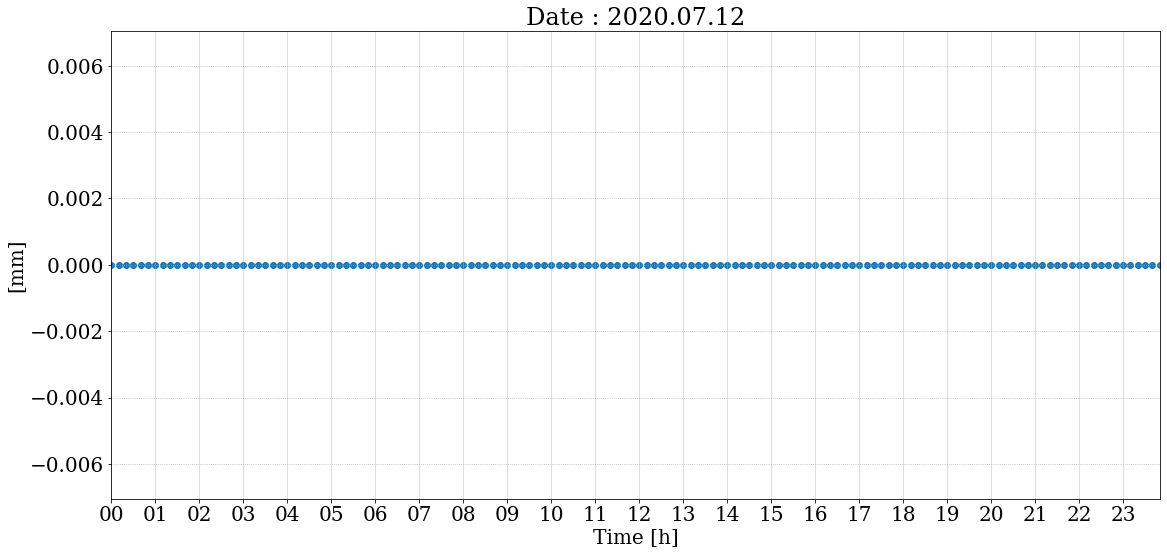

In [4]:
for chosenDate in dateList:
    if '2019' in chosenDate:
        path_rain = pathRain[0]
    elif '2020' in chosenDate:
        path_rain = pathRain[1]
        
    columns_to_keep = ['STA','JAHR','MO','TG','HH','MM','93']
    df = pd.read_table(str(path_rain), sep="\s+", usecols=columns_to_keep, skiprows=8, dtype={1:'str',2:'str', 3:'str', 4:'str', 5:'str'})

    data = df[df['TG'] == str(dt.datetime.strptime(padChosenDate(chosenDate), '%Y%m%d').day)]
    data = data[data['MO'] == str(dt.datetime.strptime(padChosenDate(chosenDate), '%Y%m%d').month)]
    data = data.reset_index(drop=True)
    data['Date']=[dt.datetime.strptime(data.loc[i]['JAHR']+data.loc[i]['MO'].zfill(2)+data.loc[i]['TG'].zfill(2)+data.loc[i]['HH'].zfill(2)+data.loc[i]['MM'].zfill(2),
                                   '%Y%m%d%H%M') for i in range(0,data.shape[0])]

    fig = plt.figure()
    plt.scatter(data['Date'], data['93']);

    plt.xlabel('Time [h]');
    plt.ylabel('[mm]');
    plt.grid(axis='x', which='major', alpha=0.5)
    plt.grid(axis='y', which='major', linestyle=':')
    plt.title('Date : '+ titleChosenDate(chosenDate))

    plt.gca().set_xlim(data['Date'].min(), data['Date'].max());
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.xticks(rotation=0);

    plt.savefig(pathSave+chosenDate+'_rain.png', bbox_inches='tight') 
    print('Saving rain graphs : '+chosenDate)
    plt.close()

# Daily Power

In [5]:
chosenDate='2020712'
folder_radar, filepaths_radar, filenames_radar, date_radar, date_radardt,radarNoFile = loadRadar(chosenDate, path_dat)
folder_lidar, filepaths_lidar, filenames_lidar, date_lidar,date_lidardt,_,_,_,lidarNoFile = loadLidar(chosenDate, path_lidar)

if (radarNoFile is False) and (lidarNoFile is False):
    lidarStart, lidarEnd, indiceMissing = lidarStartEnd(chosenDate, filepaths_lidar, reCreate=False)
    radarStart, radarEnd = radarStartEnd(chosenDate, filepaths_radar, reCreate=False) #m14 !!
    JoinedData = retrieveLidarRadialSpeed(filepaths_radar,filepaths_lidar, radarStart, radarEnd, lidarStart, lidarEnd, 
                                          radar2lidar, chosenDate, high_mode,low_mode, reCreate=False)
    
index = filterPrevious(chosenDate,date_radardt)

Loading pickle files : start and end times from the lidar for day 2020712
Loading pickle files : start and end times from the radar for day 2020712
Loading pickle files : matched radar and lidar acquisition times for day 2020712


In [6]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.getcwd()+'/MatlabFunctions/',nargout=0)

In [7]:
beam1 = np.zeros((55,len(filepaths_radar[index[0]:]))); 
beam2 = np.zeros((55,len(filepaths_radar[index[0]:]))); 
beam3 = np.zeros((55,len(filepaths_radar[index[0]:]))); 
beam4 = np.zeros((55,len(filepaths_radar[index[0]:]))); 
beam5 = np.zeros((55,len(filepaths_radar[index[0]:]))); 

for indice, k in enumerate(filepaths_radar[index[0]:]): 
    out = eng.loadPower(k.replace('/scratch/maelle/radar/',path_dat),nargout=10)
    beam1[:,indice] = np.array(out[0]).reshape(-1)
    beam2[:,indice] = np.array(out[1]).reshape(-1)
    beam3[:,indice] = np.array(out[2]).reshape(-1)
    beam4[:,indice] = np.array(out[3]).reshape(-1)
    beam5[:,indice] = np.array(out[4]).reshape(-1)

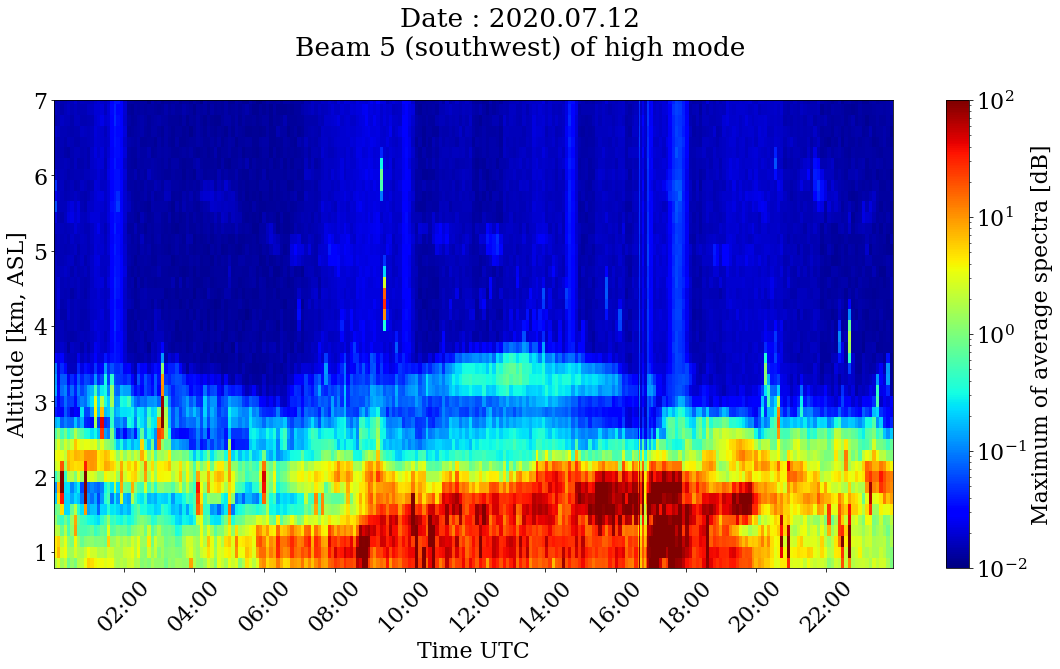

In [8]:
matplotlib.rcParams['figure.subplot.wspace'] = 0.4
fontsize1 = 22
matplotlib.rcParams.update({'font.size': 22})

light_jet = cmap_map(lambda x: x + 0.3, matplotlib.cm.jet)

fig, ax = plt.subplots();
paddedDate = padChosenDate(chosenDate)
fig.suptitle('Date : ' + paddedDate[0:4]+'.'+paddedDate[4:6]+'.'+paddedDate[6:8] 
             + '\n'+beam_radar_pretty[str(5)])
ymin = high_mode[0]/1000;ymax=7
im1 = ax.pcolormesh(date_radardt[index[0]:],high_mode/1000,beam5,cmap='jet', 
                    norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=100));
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylabel('Altitude [km, ASL]')
ax.set_xlabel('Time UTC')
ax.set_ylim(ymin,ymax);
cbar = fig.colorbar(im1, ax=ax)
cbar.set_label('Maximum of average spectra [dB]', rotation=90)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45);
plt.savefig(pathSave+chosenDate+'_dailypower.png', bbox_inches='tight') 